Timetracking:
- 28.06.21 10:00-11:00 Local Approach

In [8]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import SameTypeExplanationsNamespace, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from matplotlib.colors import Normalize
import scipy as sp
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '01'

In [20]:
with open(task_name + '.expl', 'rb') as f:
    label_explainer, proba_explainer, log_odds_explainer, explanations = pickle.load(f)
clf_a = joblib.load('model_A.joblib')
y_pred = clf_a.predict(explanations.data)

# Explain the decision boundary of a machine learning model

## Local Explanations

In [21]:
from sklearn.tree import export_text

In [22]:
n_clusters = 10
cluster_names = np.array([f'c{i+1}' for i in range(n_clusters)])
shap_values = explanations.log_odds
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
tree = DecisionTreeRegressor(max_leaf_nodes=n_clusters)
tree.fit(shap_values.data, values)

DecisionTreeRegressor(max_leaf_nodes=10)

In [23]:
leaf_node_ids = np.where(tree.tree_.children_left == -1)[0]
def predict_clusters(X):
    node_ids = tree.apply(X)
    return np.searchsorted(leaf_node_ids, node_ids)
clustering  = predict_clusters(explanations.data)
with open(task_name + '.tree', 'wb') as f:
    cloudpickle.dump((clustering, predict_clusters), f, pickle.HIGHEST_PROTOCOL)

In [24]:
occurences = np.zeros((leaf_node_ids.shape[0], len(explanations.output_names)), dtype=int)
for class_idx in range(len(explanations.output_names)):
    indices, counts = np.unique(clustering[y_pred == class_idx], return_counts=True)
    occurences[indices, class_idx] = counts
occurences = pd.DataFrame(occurences, index=leaf_node_ids, columns=explanations.output_names)

In [25]:
rules = get_rules(tree, explanations.feature_names)
print('\n'.join([f'{cluster_name}: {rule}' for cluster_name, rule in zip(cluster_names, rules)]))

c1: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN <= 24.238) [44 samples]
c2: (LSTAT > 10.165) & (LSTAT > 15.554) & (TAX > 551.5) [33 samples]
c3: (LSTAT > 10.165) & (LSTAT > 15.554) & (TAX <= 551.5) & (LSTAT <= 19.649) [30 samples]
c4: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN > 24.238) [26 samples]
c5: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT <= 7.878) [25 samples]
c6: (LSTAT > 10.165) & (LSTAT > 15.554) & (TAX <= 551.5) & (LSTAT > 19.649) [21 samples]
c7: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS <= 16.57) [20 samples]
c8: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS > 16.57) [18 samples]
c9: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT > 7.878) [15 samples]
c10: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS > 16.01) [14 samples]


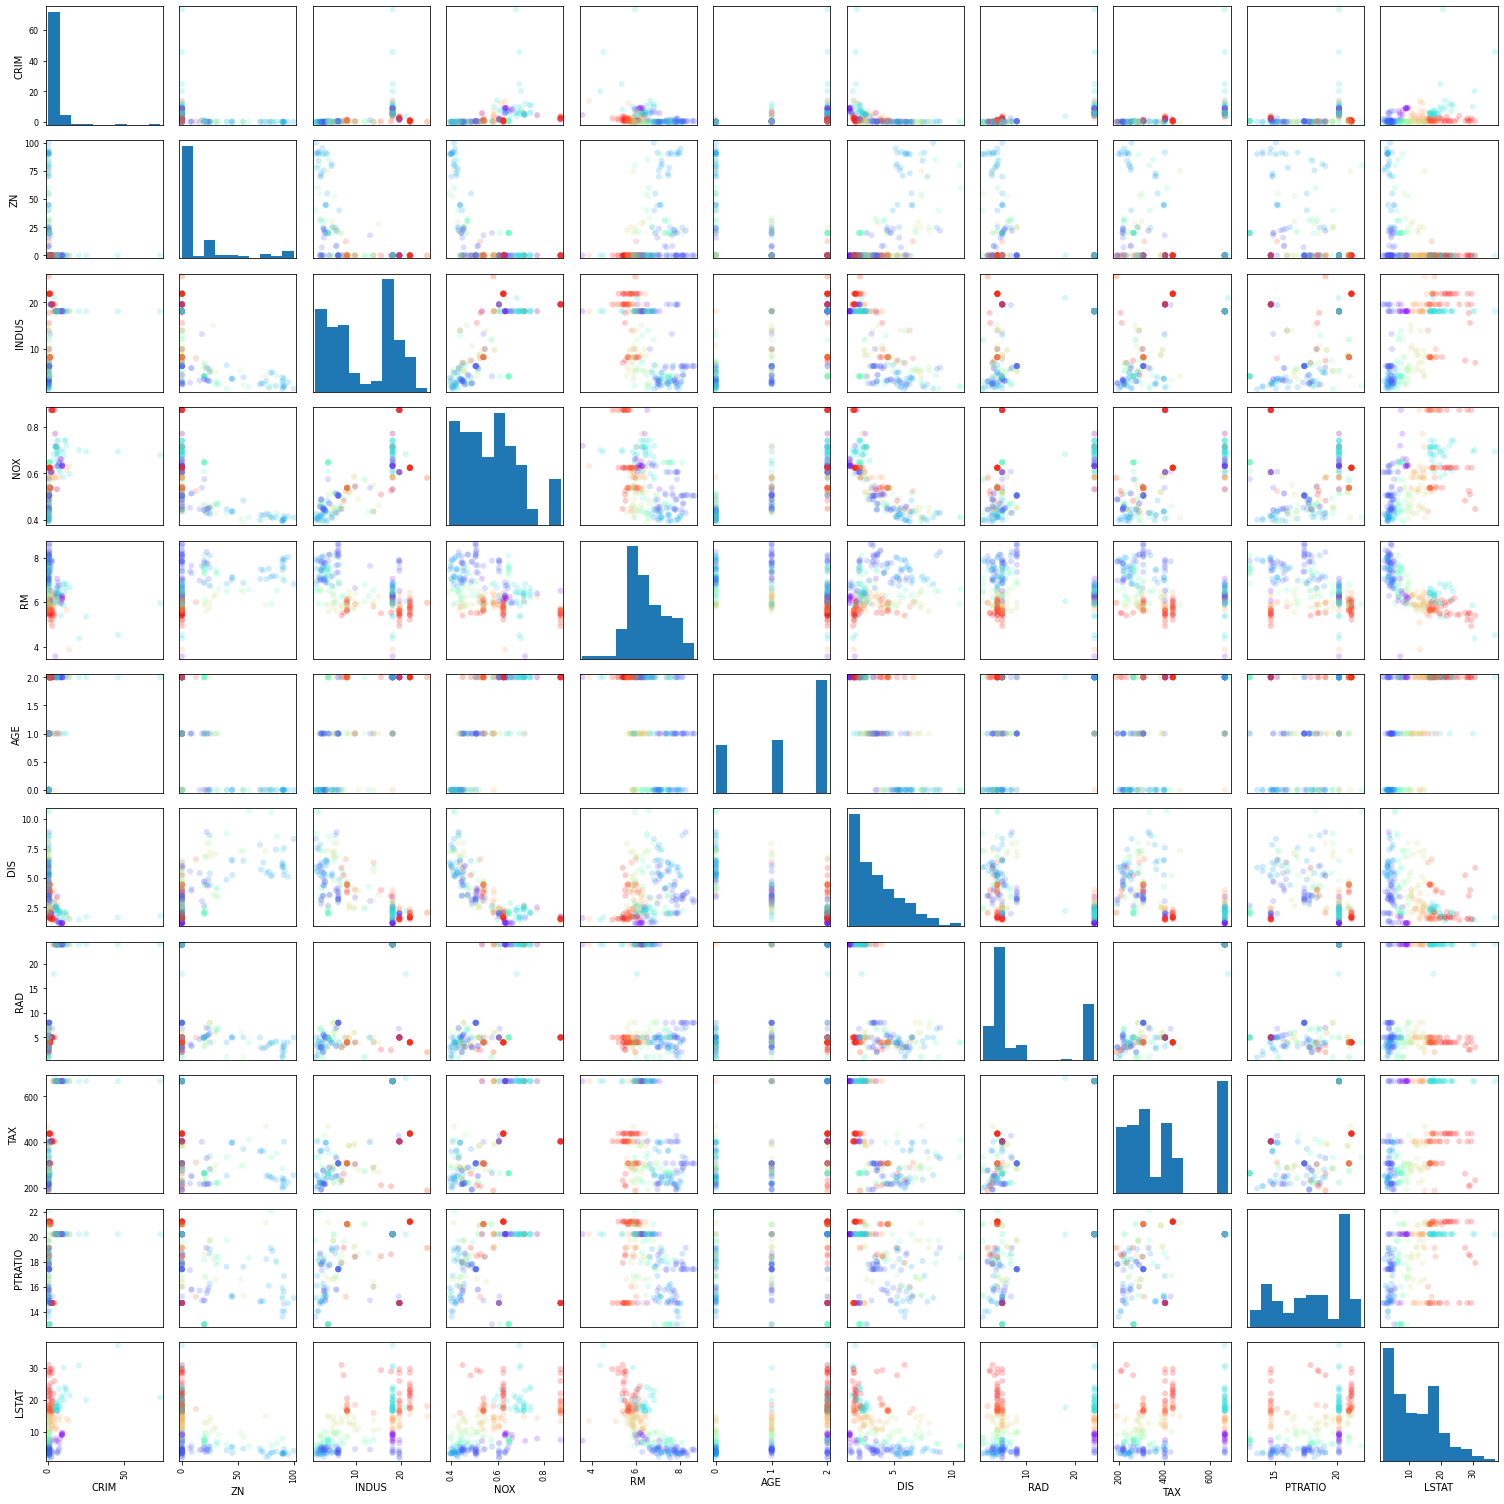

In [28]:
cmap = plt.get_cmap('rainbow')
df = pd.DataFrame(explanations.data, columns=explanations.feature_names)
colors = cmap(Normalize(0, n_clusters-1)(clustering))
axes = pd.plotting.scatter_matrix(df, figsize=(21, 21), marker='o', alpha=0.2, c=colors)
plt.tight_layout()

c1: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN <= 24.238) [44 samples]
(array([1, 2], dtype=int32), array([ 2, 12]))


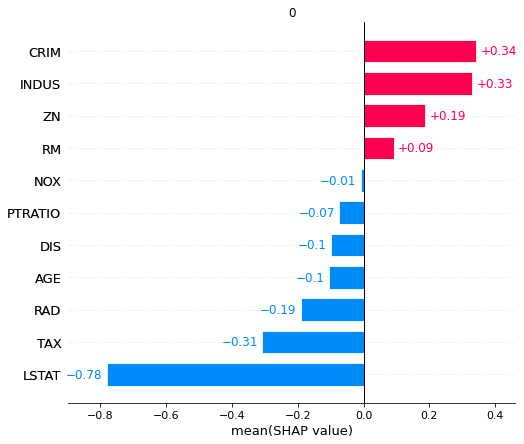

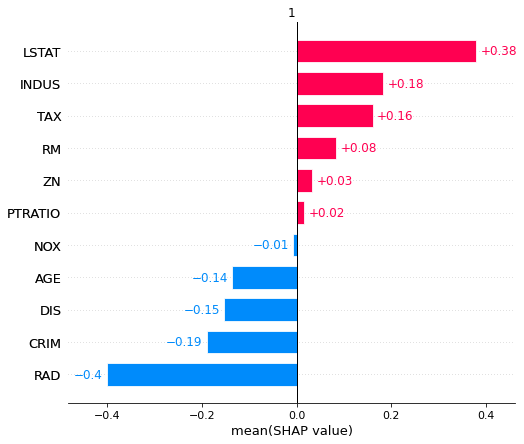

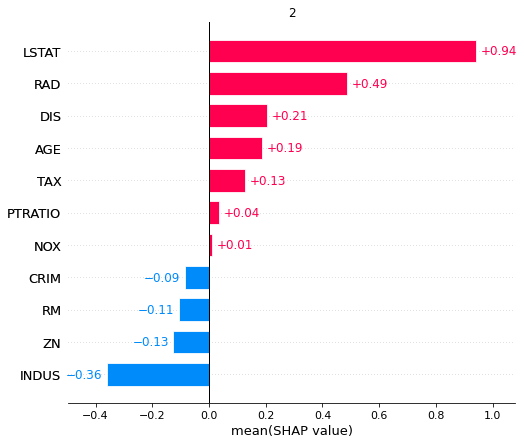

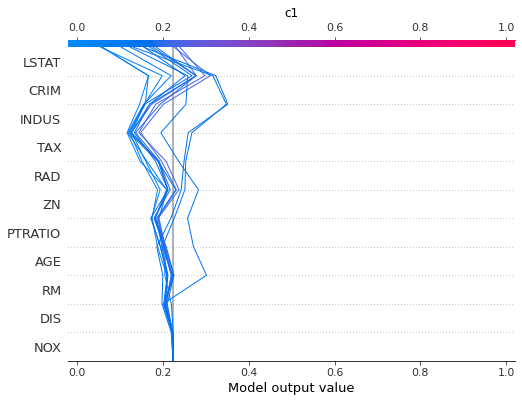

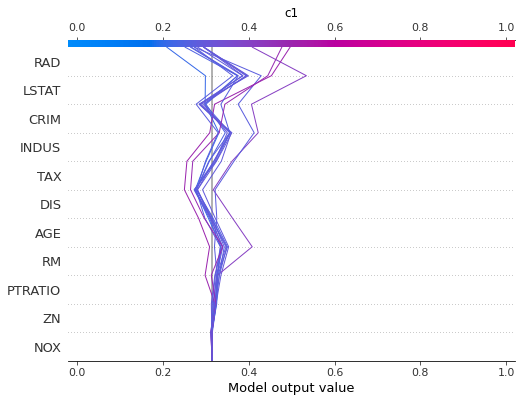

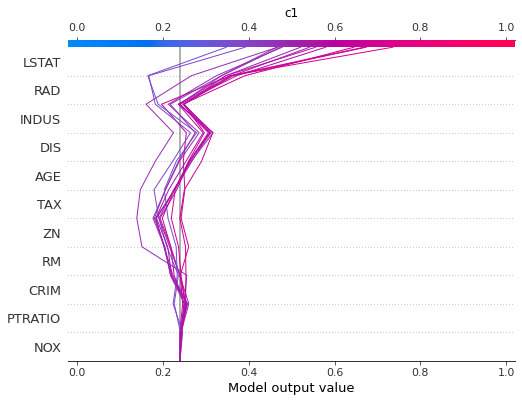

c2: (LSTAT > 10.165) & (LSTAT > 15.554) & (TAX > 551.5) [33 samples]
(array([2], dtype=int32), array([44]))


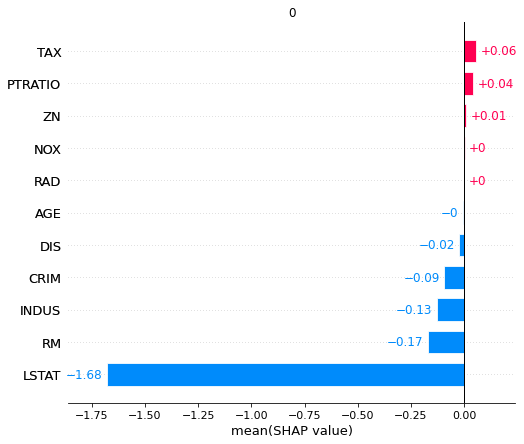

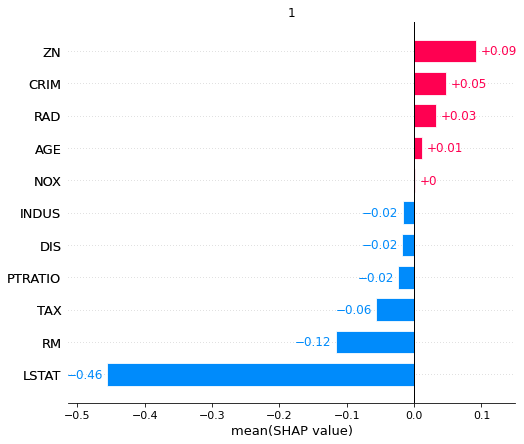

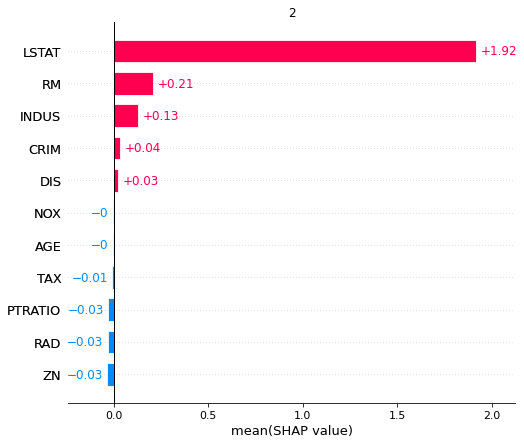

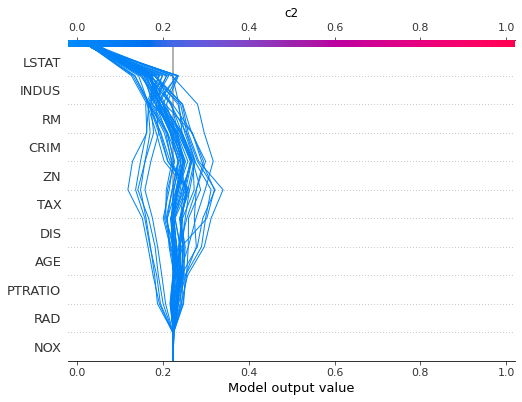

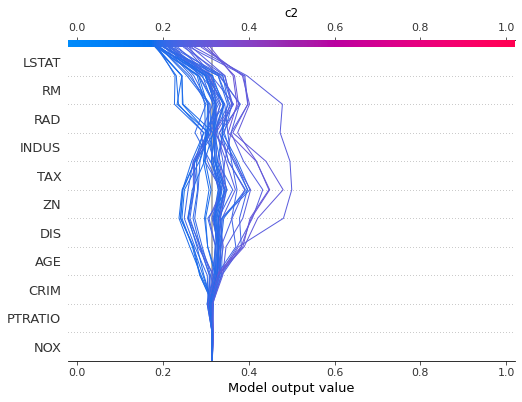

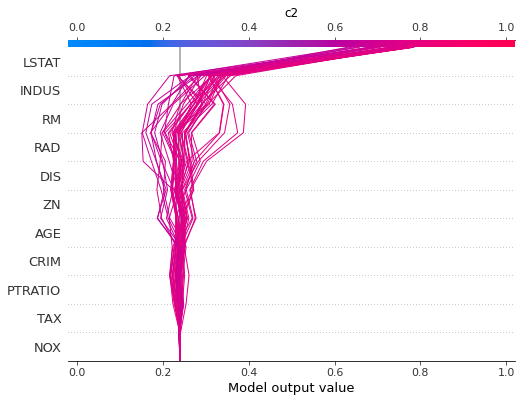

c3: (LSTAT > 10.165) & (LSTAT > 15.554) & (TAX <= 551.5) & (LSTAT <= 19.649) [30 samples]
(array([2], dtype=int32), array([26]))


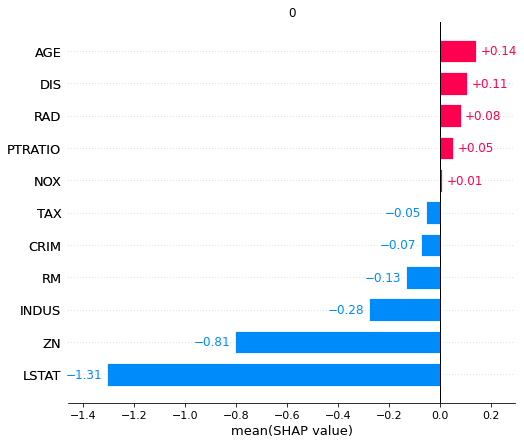

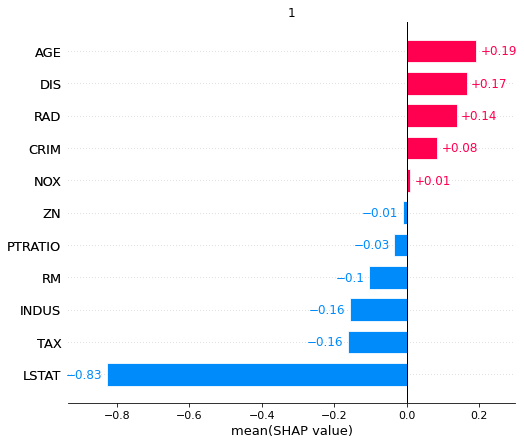

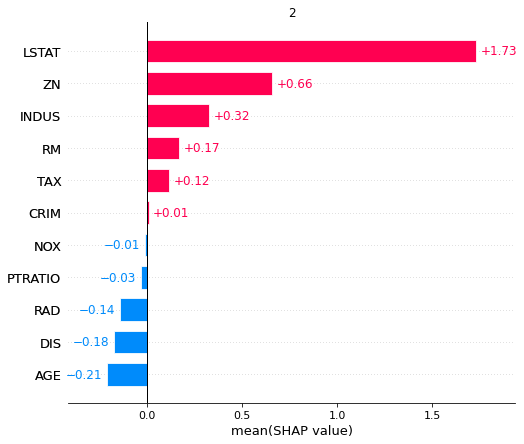

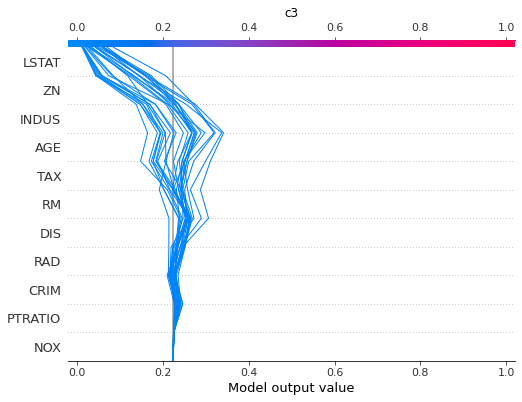

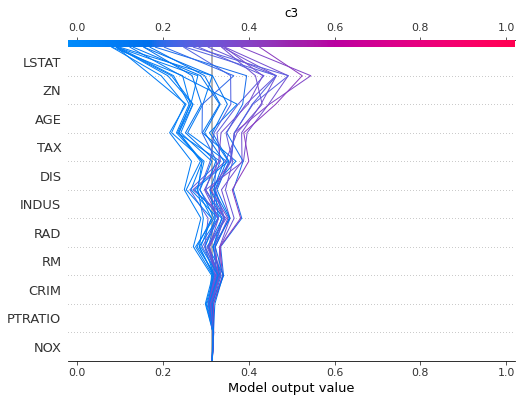

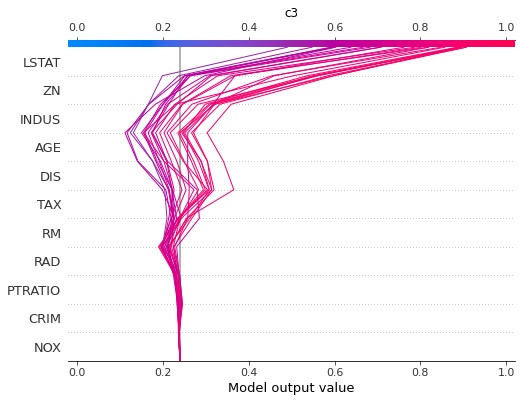

c4: (LSTAT <= 10.165) & (LSTAT <= 5.474) & (ZN > 24.238) [26 samples]
(array([0], dtype=int32), array([33]))


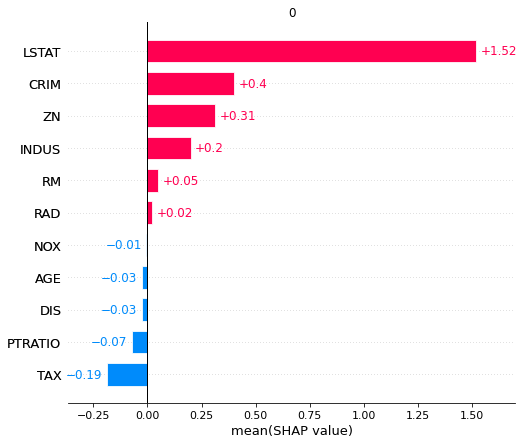

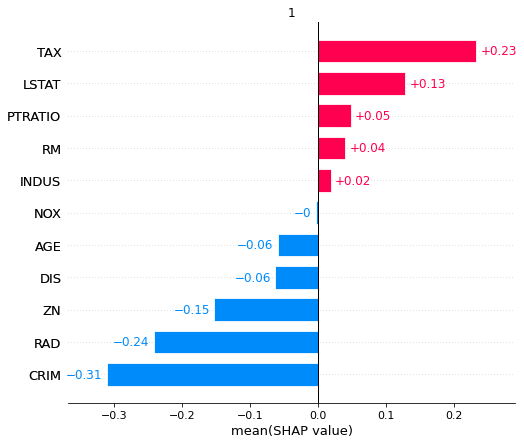

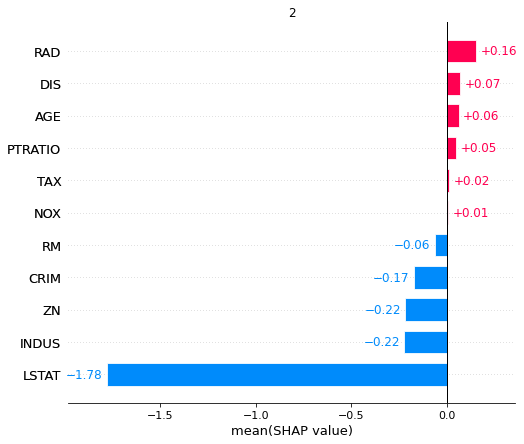

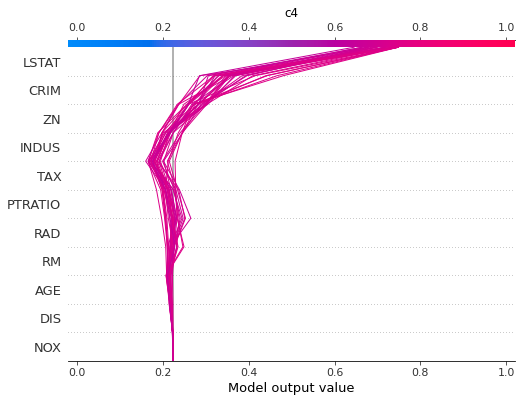

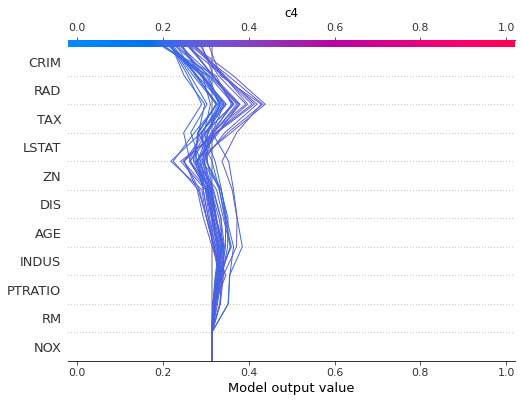

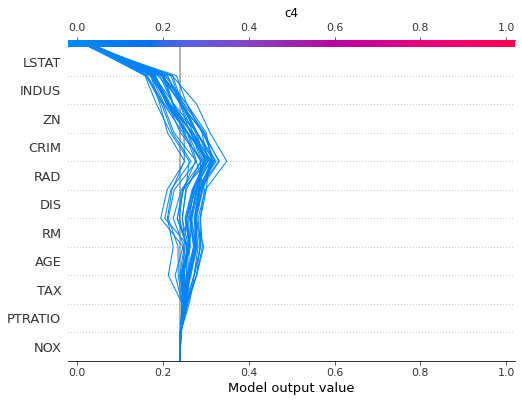

c5: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT <= 7.878) [25 samples]
(array([1, 2], dtype=int32), array([10, 15]))


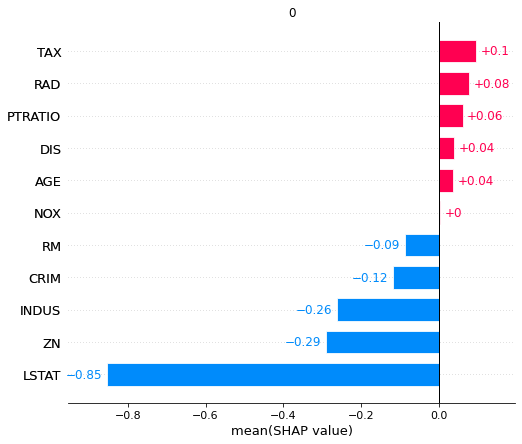

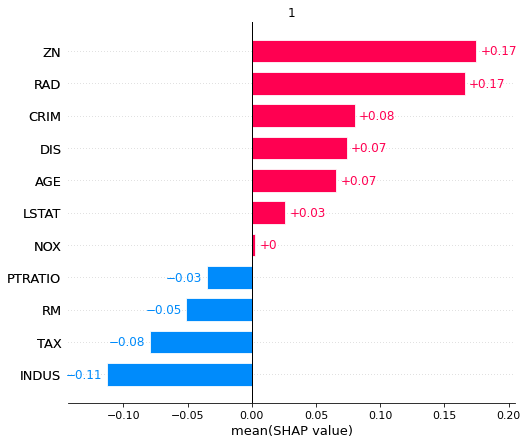

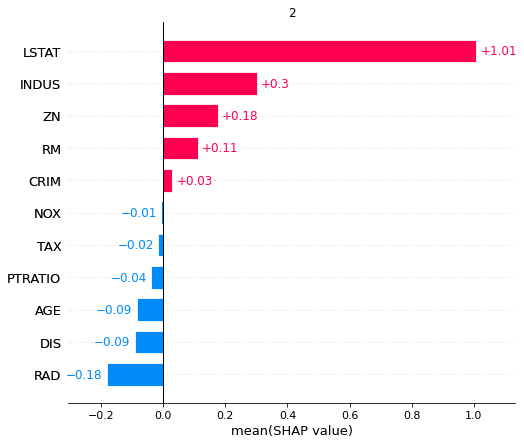

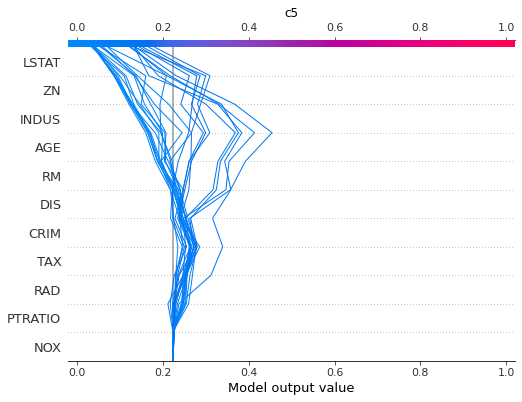

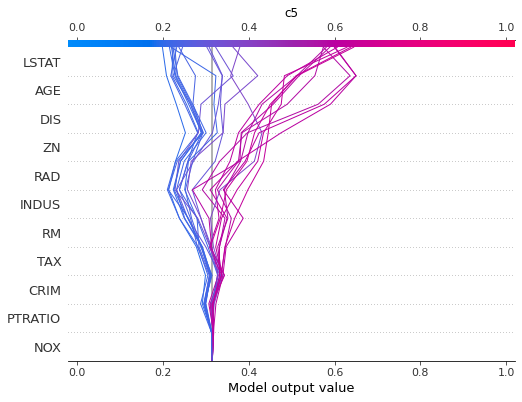

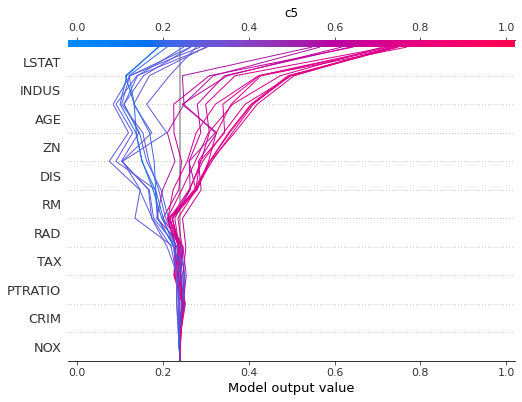

c6: (LSTAT > 10.165) & (LSTAT > 15.554) & (TAX <= 551.5) & (LSTAT > 19.649) [21 samples]
(array([1, 2], dtype=int32), array([14,  1]))


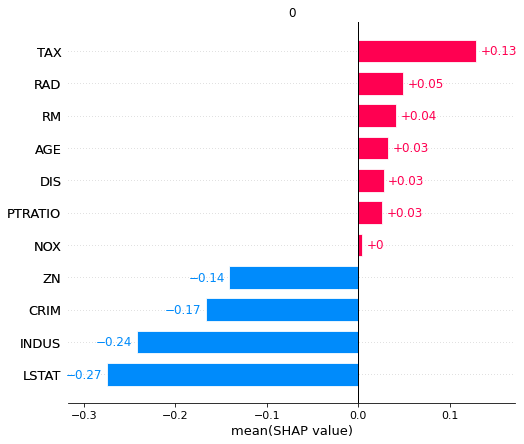

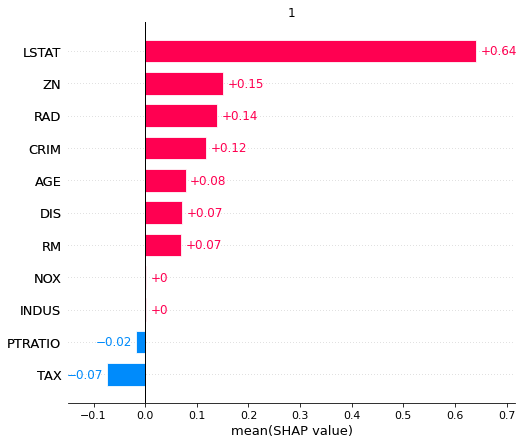

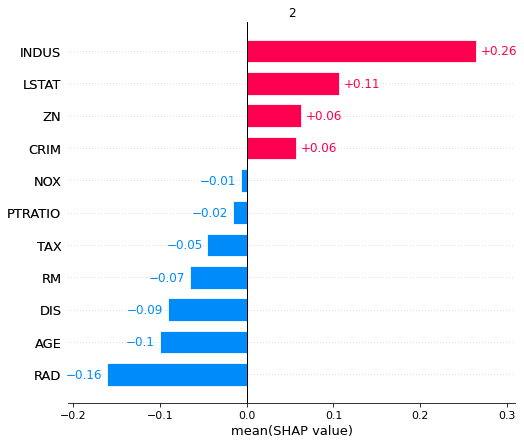

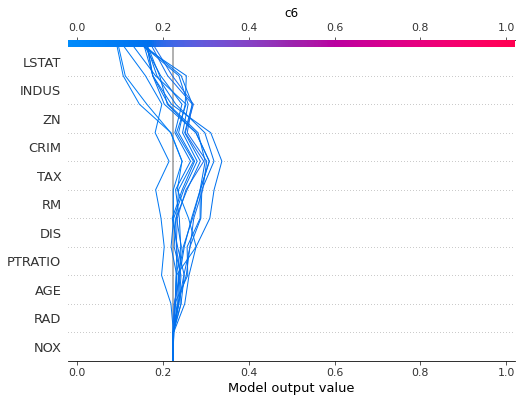

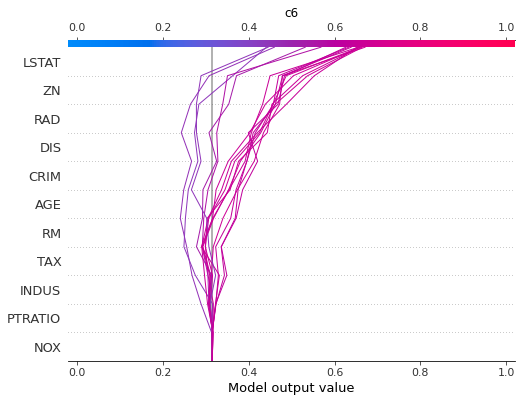

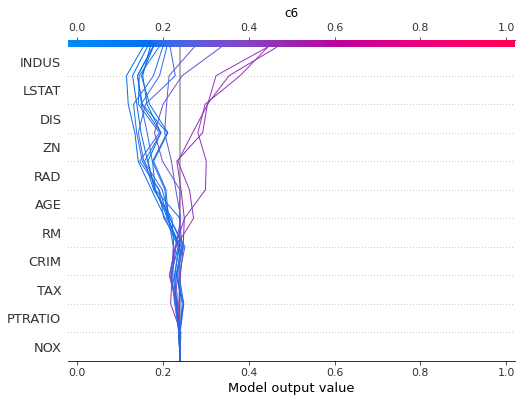

c7: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS <= 16.57) [20 samples]
(array([0, 1], dtype=int32), array([ 1, 19]))


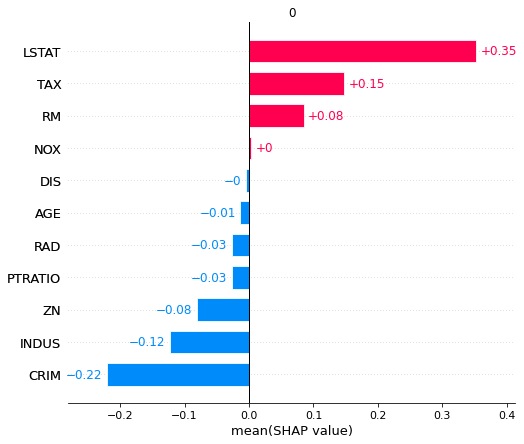

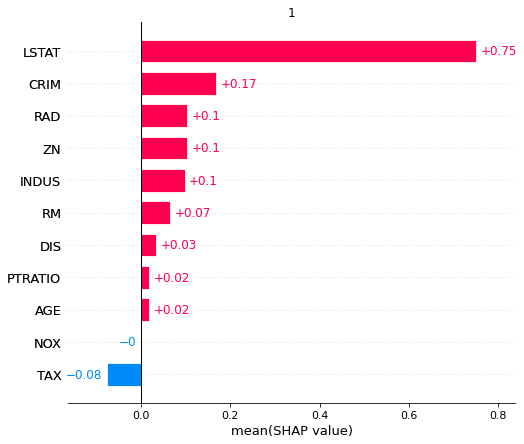

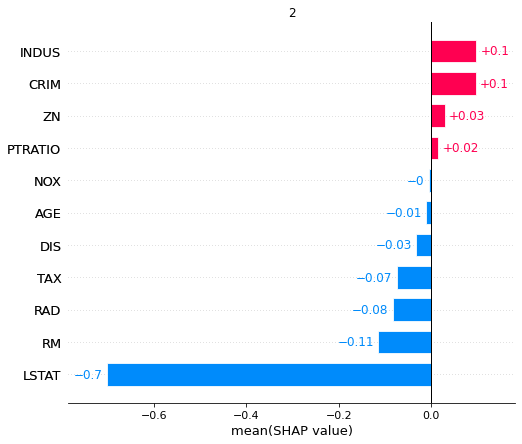

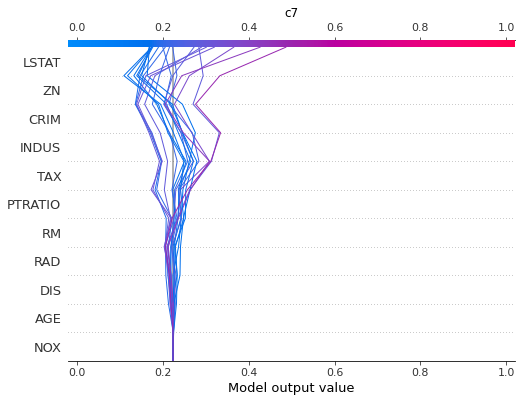

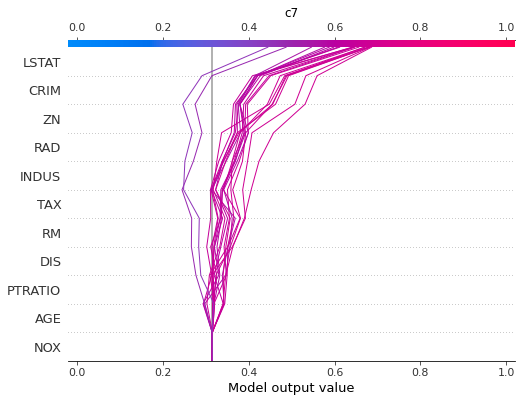

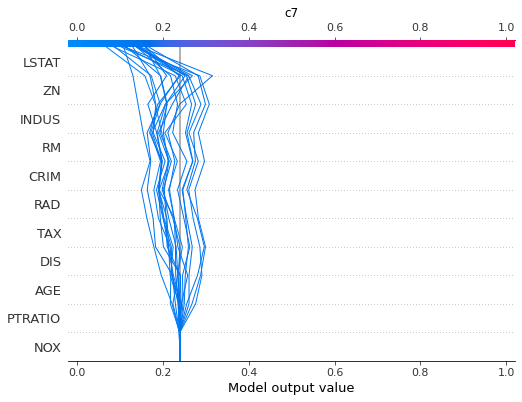

c8: (LSTAT > 10.165) & (LSTAT <= 15.554) & (INDUS > 16.57) [18 samples]
(array([0, 1], dtype=int32), array([11,  7]))


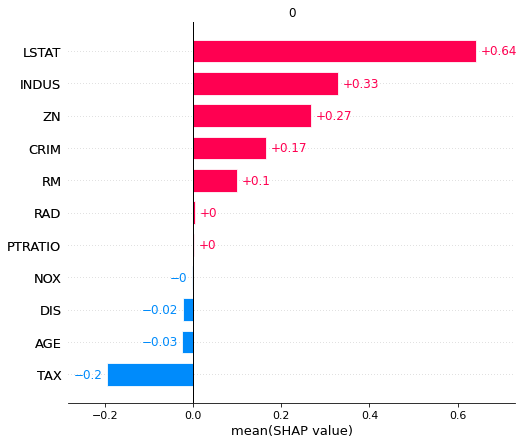

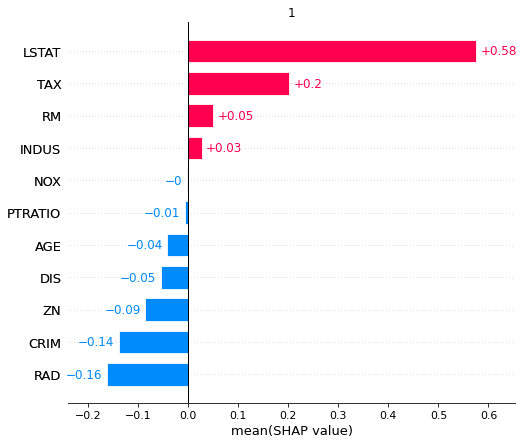

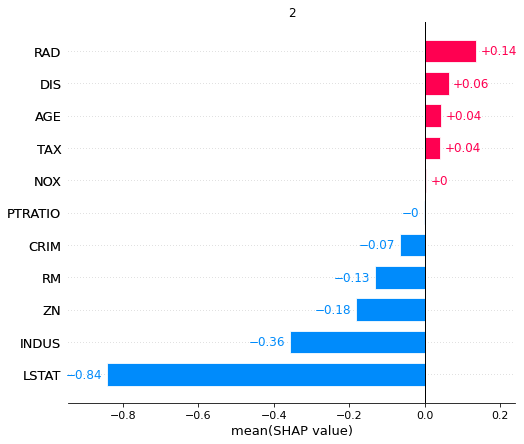

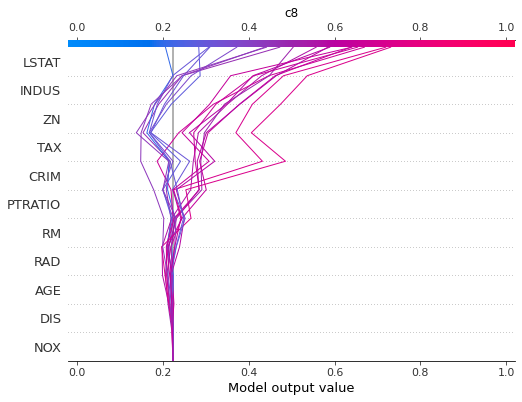

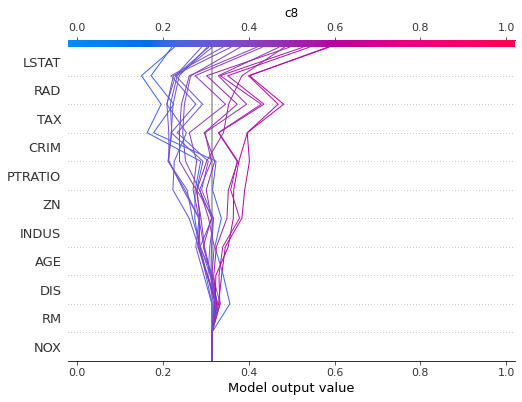

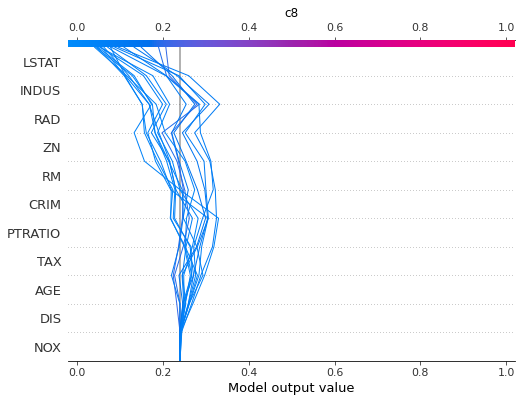

c9: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS <= 16.01) & (LSTAT > 7.878) [15 samples]
(array([0, 1], dtype=int32), array([23,  7]))


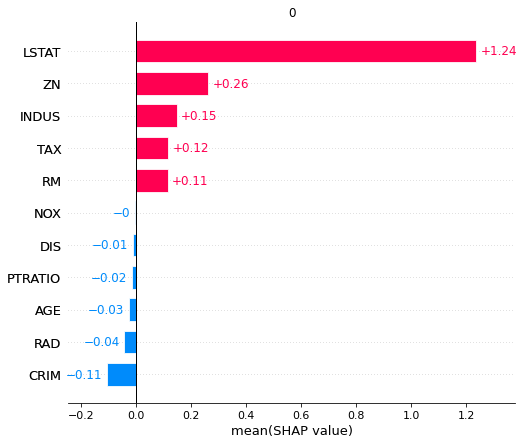

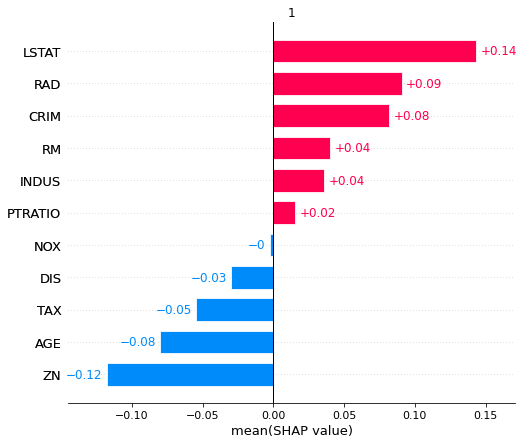

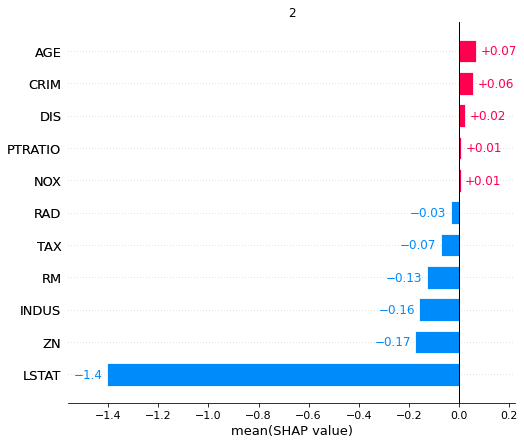

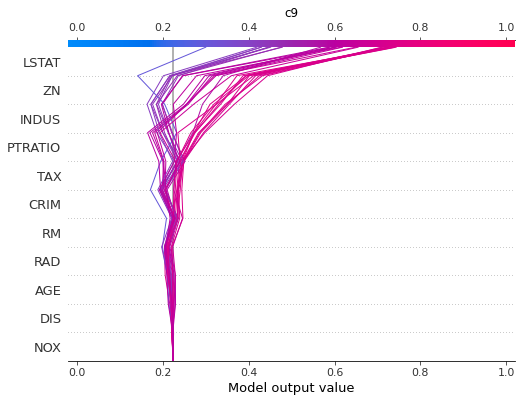

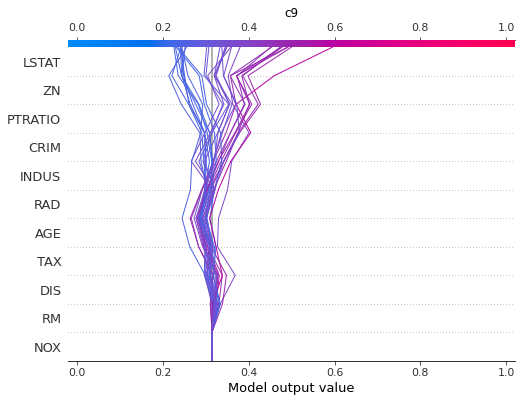

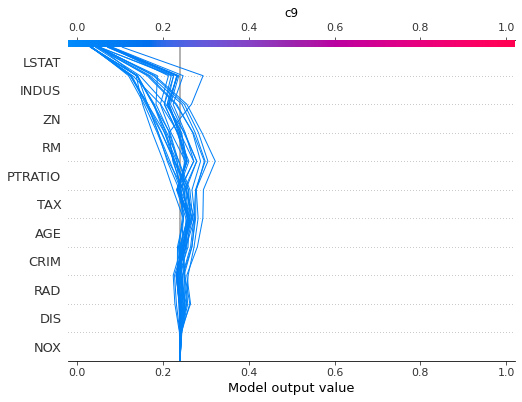

c10: (LSTAT <= 10.165) & (LSTAT > 5.474) & (INDUS > 16.01) [14 samples]
(array([0], dtype=int32), array([21]))


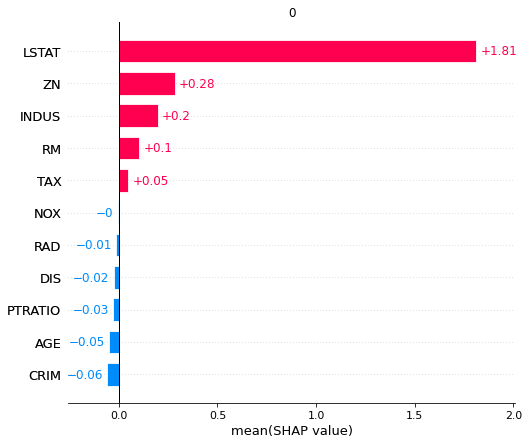

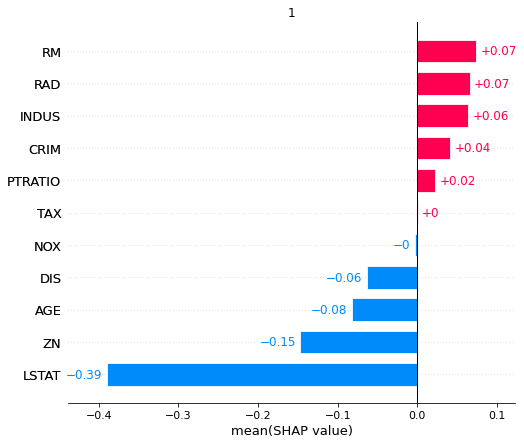

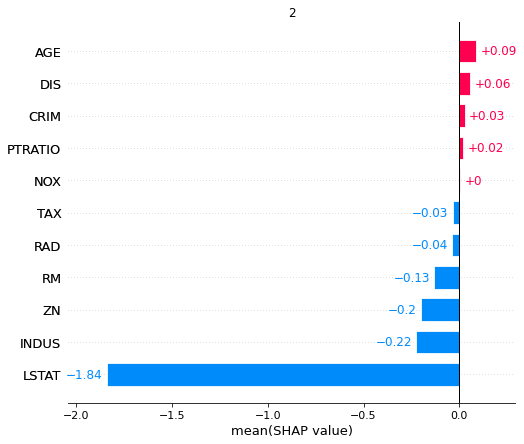

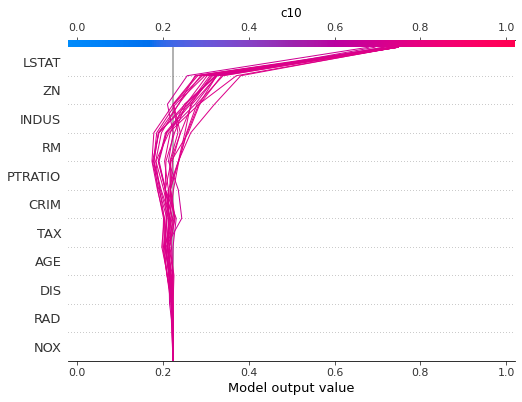

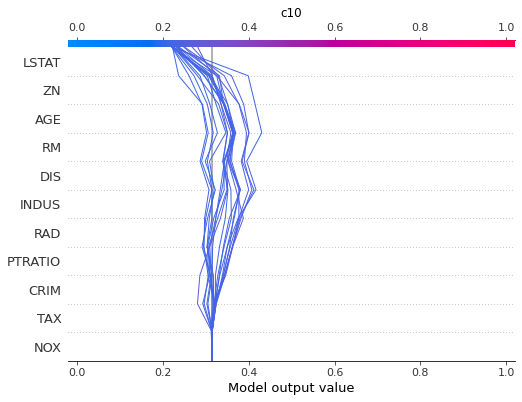

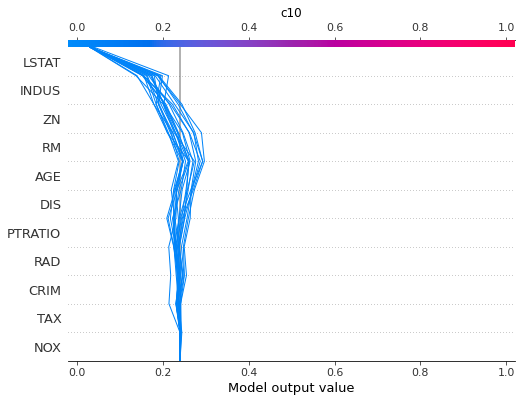

In [31]:
for cluster in range(n_clusters):
    cluster_name = cluster_names[cluster]
    print(cluster_name + ': ' + rules[cluster])
    mask = clustering == cluster
    y_pred_ = y_pred[mask]
    print(np.unique(y_pred_, return_counts=True))
    explanations_ = explanations[mask]
    shap_values  = explanations_.log_odds
    for class_idx in range(explanations_.shape[2]):
        plot_feature_importance_bar(shap_values[:, :, class_idx].mean(0), title=explanations.output_names[class_idx])
    for class_idx in range(explanations_.shape[2]):
        shap_values_ = shap_values[:, :, class_idx]
        shap.decision_plot(shap_values_.base_values[0], shap_values_.values, features=shap_values_.data,
                               feature_names=shap_values_.feature_names, link='logit', title=cluster_name)